# Railway Fault Detection
## [Dataset](https://www.kaggle.com/salmaneunus/railway-track-fault-detection)

In [1]:
train_dir = './Railway Track fault Detection Updated/Train'
val_dir   = './Railway Track fault Detection Updated/Validation'
test_dir  = './Railway Track fault Detection Updated/Test'

In [2]:
import os
train_defective_fnames = os.listdir(train_dir+'/Defective' )
train_nondefective_fnames = os.listdir(train_dir+'/Non defective')

## Show Dataset Images

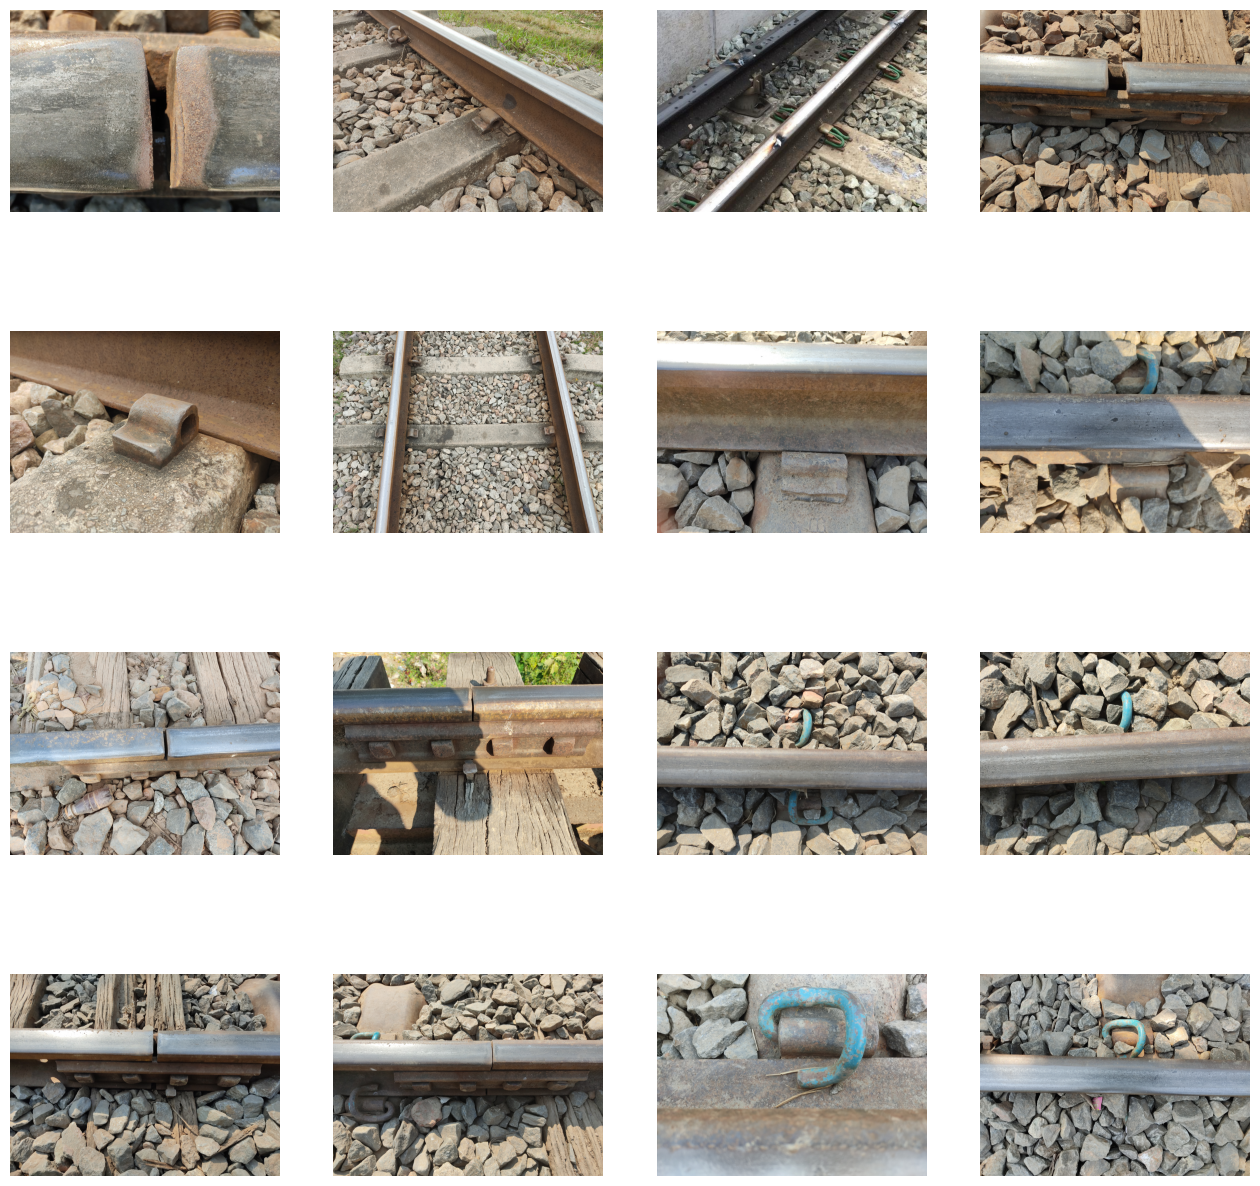

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 10x10 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_defective_pix = [os.path.join(train_dir+'/Defective', fname) 
                for fname in train_defective_fnames[pic_index-8:pic_index]]
next_nondefective_pix = [os.path.join(train_dir+'/Non defective', fname) 
                for fname in train_nondefective_fnames[pic_index-8:pic_index]]


for i, img_path in enumerate(next_defective_pix+next_nondefective_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

# plt.show()

## Data Augmentation

In [4]:
!pip install tensorflow

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

target_size=(300,300)
batch_size = 16

2022-10-13 10:07:14.861481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 10:07:15.106949: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-13 10:07:16.109412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:
2022-10-13 10:07:16.109636: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')

Found 299 images belonging to 2 classes.


In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')

Found 62 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,     
    class_mode=None)

Found 22 images belonging to 2 classes.


## Build Model

In [9]:
num_classes = 2
input_shape = (300,300,3)

In [10]:
# Build Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import models, layers

base_model=ResNet50V2(input_shape=input_shape,weights='imagenet',include_top=False) 
base_model.trainable = False # freeze the base model (for transfer learning)

# add Fully-Connected Layers to Model
x=base_model.output
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(128,activation='relu')(x)  # FC layer 
preds=layers.Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

model=models.Model(inputs=base_model.input,outputs=preds)
model.summary()

2022-10-13 10:07:17.989553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 10:07:18.070981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 10:07:18.071405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 10:07:18.072693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [12]:
## set Checkpoint : save best only, verbose on
#checkpoint = callbacks.ModelCheckpoint("railtrack_resnet50v2.hdf5", monitor='accuracy', verbose=0, save_best_only=True, mode='auto', save_freq=1)

## Train Model

In [13]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VAL  =val_generator.n//val_generator.batch_size
STEP_SIZE_TEST =test_generator.n//test_generator.batch_size
num_epochs = 30

In [14]:
# Train Model
history = model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,epochs=num_epochs, validation_data=val_generator, validation_steps=STEP_SIZE_VAL) #, callbacks=[checkpoint])

Epoch 1/30


2022-10-13 10:07:35.301265: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 17.27M (18107392 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-10-13 10:07:35.308942: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 17.27M (18107392 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-10-13 10:07:35.316720: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 17.27M (18107392 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-10-13 10:07:45.316923: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 17.27M (18107392 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-10-13 10:07:45.324629: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 17.27M (18107392 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-10-13 10:07:45.324771: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran o

ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[16,3,306,306] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv1_conv/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_8431]

## Save Model

In [ ]:
## Save Model
models.save_model(model, 'railway_track_resnet50v2.h5')

In [ ]:
## load best model weights if using callback (save-best-only)
#model.load_weights("railtrack_resnet50v2.hdf5")

## Evaluate Model

In [ ]:
score = model.evaluate(test_generator, steps=STEP_SIZE_TEST) # with test dataset
print(score)

## Confusion Matrix

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

predY=model.predict(test_generator) # with validation dataset
y_pred = np.argmax(predY,axis=1)
y_actual = test_generator.classes
cm = confusion_matrix(y_actual, y_pred)
print(cm)

In [ ]:
# report confusion matrix
labels = ['Defective', 'Non Defective']
print(classification_report(y_actual, y_pred, target_names=labels))

## Training History

In [ ]:
# Show Train History
keys=history.history.keys()
print(keys)

def show_train_history(hisData,train,val): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[val])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

show_train_history(history, 'loss', 'val_loss')
show_train_history(history, 'accuracy', 'val_accuracy')

In [ ]:
import cv2
import numpy as np
img = cv2.imread("../input/railway-track-fault-detection/Railway Track fault Detection Updated/Test/Defective/IMG_20201114_100344.jpg")
plt.imshow(img)
img = cv2.resize(img,(300,300))
img = np.reshape(img,[1,300,300,3])

classes = model.predict(img)

print(classes)
# if classes<0.5 : non=defective
# else defective